In [16]:
import random
import operator

import numpy as np
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import pandas as pd

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

import math

In [17]:
"""
NOTE:

Terminals - min/max/avg of columns, 0, 1, -1

Mutations - mutShrink and mutNodeReplacement with 50% chance of picking one or the other is what I used in lab 2

Objectives - individual size, FP, FN, inaccuracy

primitives: power 2, power -1, power 3
"""

'\nNOTE:\n\nTerminals - min/max/avg of columns, 0, 1, -1\n\nMutations - mutShrink and mutNodeReplacement with 50% chance of picking one or the other is what I used in lab 2\n\nObjectives - individual size, FP, FN, inaccuracy\n\nprimitives: power 2, power -1, power 3\n'

In [18]:
# will minimize fp's, fn's, tree depth, and inaccuracy
# fitness will be tuple: (fp's, fn's, tree depth, inaccuracy)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0,-0.5))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

/opt/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [19]:
# load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [20]:
# preprocess data

train_data.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
train_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

test_data.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
test_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

train_nan_map = {'Age': train_data['Age'].mean(), 'Fare': train_data['Fare'].mean(), 'Embarked': train_data['Embarked'].mode()[0]}
test_nan_map = {'Age': test_data['Age'].mean(), 'Fare': test_data['Fare'].mean(), 'Embarked': test_data['Embarked'].mode()[0]}

train_data.fillna(value=train_nan_map, inplace=True)
test_data.fillna(value=test_nan_map, inplace=True)

train_data = pd.get_dummies(train_data, columns=['Embarked'], dtype=int)
test_data = pd.get_dummies(test_data, columns=['Embarked'], dtype=int)

train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

columns_map = {'Sex': {'male': 0, 'female': 1}}
train_data.replace(columns_map, inplace=True)
test_data.replace(columns_map, inplace=True)

X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

x_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=10)

/var/folders/21/k1c5gbs95m14xwrmrbkjd2680000gn/T/ipykernel_31288/1101249441.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data.replace(columns_map, inplace=True)
/var/folders/21/k1c5gbs95m14xwrmrbkjd2680000gn/T/ipykernel_31288/1101249441.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data.replace(columns_map, inplace=True)


In [21]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,0,0,1
2,1,1,1,38.0,1,0,71.2833,1,0,0
3,1,3,1,26.0,0,0,7.9250,0,0,1
4,1,1,1,35.0,1,0,53.1000,0,0,1
5,0,3,0,35.0,0,0,8.0500,0,0,1


In [22]:
test_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
892,0,3,0,34.5,0,0,7.8292,0,1,0
893,0,3,1,47.0,1,0,7.0000,0,0,1
894,0,2,0,62.0,0,0,9.6875,0,1,0
895,0,3,0,27.0,0,0,8.6625,0,0,1
896,0,3,1,22.0,1,1,12.2875,0,0,1


In [23]:
# section to compute terminals
# features: sex, age, sibsp, parch, ticket, fare, embarked
# types: int, bool, float, int, int, int, float, int

min_data = x_train[['Age', 'Fare']].min(axis=0)
max_data = x_train[['Age', 'Fare']].max(axis=0)

age_avg = np.average(x_train.loc[:, 'Age'])
fare_avg = np.average(x_train.loc[:, 'Fare'])
row_sums = x_train.sum(axis=1)
feature_sum_avg = np.average(row_sums)
print(min_data,max_data,age_avg,fare_avg,feature_sum_avg)

Age     0.42
Fare    0.00
dtype: float64 Age      80.0000
Fare    512.3292
dtype: float64 29.87112761547572 33.48298288590604 67.94471452822741


In [24]:
random.seed(50)

# funcion to convert float to bool
def float_to_bool(x: float) -> bool:
    if x > 0:
        return True
    else:
        return False
def bool_to_float(x):
    return float(1 if x else 0)

# add primitives to typed primitive set
# using typed set to ensure boolean output
# we have 9 inputs, of types:
in_types = [float, bool, float, float, float, float, bool, bool, bool]
#in_types = [float, bool, float, float, float, float, float, float]
pset = gp.PrimitiveSetTyped("MAIN", in_types, bool)
pset.addPrimitive(np.add, [float, float], float)
pset.addPrimitive(np.subtract, [float, float], float)     # TODO: might need to change all inputs to be floats...
pset.addPrimitive(np.multiply, [float, float], float)
pset.addPrimitive(np.negative, [float], float)
pset.addPrimitive(np.greater, [float, float], bool)
pset.addPrimitive(np.less, [float, float], bool)
pset.addPrimitive(np.logical_or, [bool, bool], bool)
pset.addPrimitive(np.logical_and, [bool, bool], bool)
pset.addPrimitive(np.logical_not, [bool], bool)

pset.addPrimitive(float_to_bool, [float], bool)
pset.addPrimitive(bool_to_float, [bool], float)
# add terminals
pset.addTerminal(age_avg, float, name='age_avg')
pset.addTerminal(fare_avg, float, name='fare_avg')
pset.addTerminal(feature_sum_avg, float, name='feature_sum_avg')


# rename 9 inputs
pset.renameArguments(ARG0='pclass')
pset.renameArguments(ARG1='sex')
pset.renameArguments(ARG2='age')
pset.renameArguments(ARG3='sibsp')
pset.renameArguments(ARG4='parch')
pset.renameArguments(ARG5='fare')
pset.renameArguments(ARG6='embarked_C')
pset.renameArguments(ARG7='embarked_S')
pset.renameArguments(ARG8='embarked_Q')

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=6, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


In [25]:
def evalIndividual(individual, x_values, y_values, pset, *args, **kwargs):
    func = gp.compile(expr=individual, pset=pset)

    y_pred = [func(*x) for x in x_values]

    y_values = np.array(y_values)
    y_pred = np.array(y_pred, dtype=bool)

    fps = np.sum((y_values == 0) & (y_pred == True))
    fns = np.sum((y_values == 1) & (y_pred == False))
    
    return (fps, fns, len(individual))

x_train = x_train.values.tolist()
y_train = y_train.values.tolist()
toolbox.register("evaluate", evalIndividual, x_values=x_train, y_values=y_train, pset=pset)
toolbox.register("select", tools.selNSGA3, ref_points=tools.uniform_reference_points(nobj=3, p=10), nd='standard', return_memory=False)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=8)

def mutCustom(ind, expr, pset):
    if random.random() < 0.5:
        return gp.mutInsert(gp.mutInsert(ind, pset)[0], pset)
    else:
        return gp.mutShrink(gp.mutShrink(ind)[0])

toolbox.register("mutate", mutCustom, expr=toolbox.expr_mut, pset=pset)
toolbox.register("mutate_node", gp.mutNodeReplacement, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=9))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=9))
toolbox.decorate("mutate_node", gp.staticLimit(key=operator.attrgetter("height"), max_value=9))

In [26]:
#gen = range(200)
gen = range(150)
numSelect = 100
numOffspring = 900
mutPb = 0.4
crossoverPb = 0.6

hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

pop = toolbox.population(n=numSelect)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
# normalized_fitnesses = toolbox.normalize(fitnesses)
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = tuple(fit)

hof.update(pop)
print(stats.compile(pop))

fpList = []
npList = []

for g in gen:
    offspring = []
    for i in range(numOffspring):
        r = random.random()
        if r < crossoverPb:
            parent1, parent2 = toolbox.clone(random.choice(pop[::2])), toolbox.clone(random.choice(pop[1::2]))
            parent1, _ = toolbox.mate(parent1, parent2)
            del parent1.fitness.values
            offspring.append(parent1)
        elif r > 1 - mutPb:
            mutant = toolbox.clone(random.choice(pop))
            mutant = toolbox.mutate(mutant)[0]
            del mutant.fitness.values
            offspring.append(mutant)
    while len(offspring) < numOffspring:
        offspring.append(random.choice(pop))

    #evaluate invalid-fitness individuals
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalid_ind))
    # normalized_fitnesses = toolbox.normalize(fitnesses)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = tuple(fit)

    hof.update(offspring)
    pop[:] = toolbox.select(pop + offspring, numSelect)
    curStats = stats.compile(pop)
    fpList.append(curStats['avg'][0])
    npList.append(curStats['avg'][1])
    print("Gen", g+1, stats.compile(pop))
    # print("Generation:", g+1)

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    


{'avg': array([187.3 , 108.51,  88.19]), 'std': array([161.36626041, 102.71080712,  83.99496354]), 'min': array([ 0.,  0., 12.]), 'max': array([358., 238., 492.])}
Gen 1 {'avg': array([184.36,  89.7 ,  50.2 ]), 'std': array([138.8491642 ,  76.76164407,  41.9926184 ]), 'min': array([0., 0., 2.]), 'max': array([358., 238., 204.])}
Gen 2 {'avg': array([132.34, 115.81,  41.96]), 'std': array([133.93873376,  82.57126558,  43.72731869]), 'min': array([0., 0., 2.]), 'max': array([350., 238., 174.])}
Gen 3 {'avg': array([131.89,  98.38,  42.64]), 'std': array([127.06477836,  72.411709  ,  48.9437473 ]), 'min': array([0., 0., 2.]), 'max': array([350., 238., 159.])}
Gen 4 {'avg': array([116.68, 101.27,  41.49]), 'std': array([118.60100168,  73.11741995,  44.14124942]), 'min': array([0., 0., 2.]), 'max': array([350., 238., 152.])}
Gen 5 {'avg': array([128.03,  88.75,  34.49]), 'std': array([119.90908681,  68.76109001,  41.39915337]), 'min': array([0., 0., 2.]), 'max': array([350., 238., 153.])}
G

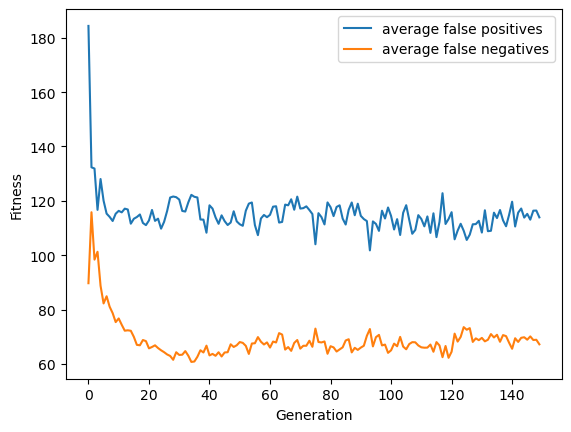

In [27]:
plt.plot(gen, fpList, label="average false positives")
plt.plot(gen, npList, label="average false negatives")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()

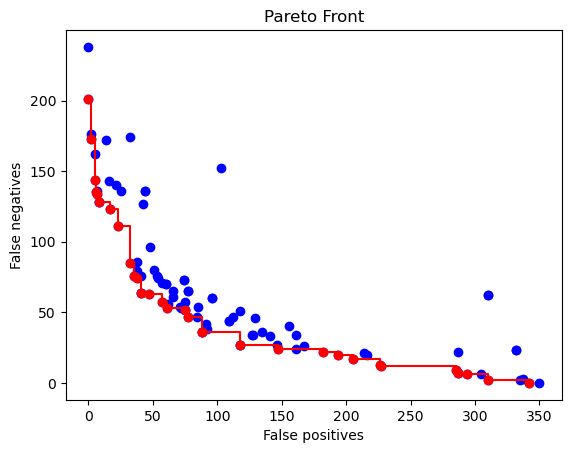

Area Under Curve: 12013.0


In [28]:
hof_new = tools.ParetoFront()

pop_fpnp = []
for ind in pop:
    ind_clone = toolbox.clone(ind)
    ind_clone.fitness.weights = ind_clone.fitness.weights[0:2]
    ind_clone.fitness.values = ind_clone.fitness.values[0:2]
    pop_fpnp.append(ind_clone)

hof_new.update(pop_fpnp)

"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof_new]
fitness_2 = [ind.fitness.values[1] for ind in hof_new]
pop_1 = [ind.fitness.values[0] for ind in pop]
pop_2 = [ind.fitness.values[1] for ind in pop]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("False positives")
plt.ylabel("False negatives")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

In [29]:

best = pop[0]
for ind in pop:
    if best.fitness.values[0] + best.fitness.values[1] > ind.fitness.values[0] + ind.fitness.values[1]:
        best= ind
print(best.fitness.values)
print(best)

func = gp.compile(expr=best, pset=pset)
predictions = [int(func(*x)) for x in test_data.values]

pred_df = pd.DataFrame(predictions, index=test_data.index, columns=['Survived'])
type(pred_df)
pred_df
pred_df.to_csv('predictions.csv', header=True, sep=',')

(41.0, 64.0, 39.0)
logical_and(logical_or(logical_or(less(subtract(fare_avg, multiply(add(bool_to_float(sex), age_avg), subtract(age_avg, multiply(age, pclass)))), pclass), sex), sex), float_to_bool(subtract(subtract(fare, subtract(add(pclass, sibsp), subtract(add(add(sibsp, fare_avg), fare), age))), multiply(sibsp, multiply(parch, age_avg)))))


TypeError: <lambda>() takes 9 positional arguments but 10 were given